## Apply Zhang and Uhlhorn 2012

In ZU12, Vmax and Vs are obtained from best-tracks.

For Rmax: "The Rmax value represents an average of individually observed wind maxima along each radial leg for a single flight." Thus I will take the Rmax_1D.

Phase is clockwise from storm motion.

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
from scipy.optimize import minimize

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
# Paths & Params
PTHS = {
    'dsg_pth': '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sar_dir': '/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/',
    'sav_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_ZU12/',
}

PRMS = {
    'sav_fgs': True,
    'sav_css': True,
}

# Open data
dsg = xr.open_dataset(PTHS['dsg_pth'])

In [3]:
# FILTERS
cond = (
    (dsg.center_quality_flag < 2) & 
    (dsg.percent_outside < 10) & 
    (dsg.percent_rmx_inside == 1) &
    (abs(dsg.lat) < 30) & 
    (dsg.rmx < 100000) & 
    (dsg.vmx > 20) &
    (dsg.dist2coast  > dsg.r34)              # Distance to coast
    # ((dsg.storm_speed_ibt / dsg.vws_pmd) > 1) # Ratio storm_speed / wind_shear
)
dsg_filtered    = dsg.where(cond, drop=True)
print(len(dsg_filtered.time))

472


In [12]:
##############################
### Zhand and Uhlhorn 2012 ###
##############################
def inflow_angle(r_star, theta, vmax, vs):
    '''theta must be in radians.'''
    return Aa0(r_star, vmax) + Aa1_Aa0(r_star, vs) * Aa0(r_star, vmax) * np.cos(theta - np.deg2rad(Pa1(r_star, vs)))

def Aa0(r_star, vmax):
    '''output is in degrees.'''
    # aA0 = -0.90 
    aA0 = -0.90 - 0.2 # To match Fig. 12
    # bA0 = -0.90 
    bA0 = -0.11 # To match Fig. 12
    # cA0 = -14.33 
    cA0 = -12.8 # To match Fig. 12
    return aA0 * r_star + bA0 * vmax + cA0

def Aa1_Aa0(r_star, vs):
    aA1 = 0.04
    bA1 = 0.05
    # cA1 = 0.14
    cA1 = 0.09 # To match Fig. 13
    return -(aA1 * r_star + bA1 * vs + cA1)

def Pa1(r_star, vs):
    '''output is in degrees'''
    aP1 = 6.88
    bP1 = -9.60
    # cP1 = 85.31
    cP1 = 80 # To match Fig. 13
    return aP1 * r_star + bP1 * vs + cP1

#########################
### General functions ###
#########################

def pol2cart(r, th):
    x = r * np.cos(th)
    y = r * np.sin(th)
    return x, y

from scipy.interpolate import griddata

### Create ref. grid, choose resolution
dim_ref      = np.linspace(-10, 10, 81)
x_ref, y_ref = np.meshgrid(dim_ref, dim_ref)

def get_cartesian_var_from(Rs, THs, var):
    ds_x, ds_y = pol2cart(Rs, THs)
    var_car    = griddata((ds_x.flatten(), ds_y.flatten()), var.flatten(), (x_ref, y_ref), method='nearest')
    return var_car

In [22]:
# Prepare new_dsg
listOfDatasets  = []

for t in tqdm(range(len(dsg_filtered.time))[:1]):
    # Open
    ds  = dsg_filtered.isel(time=t)
    dsp = xr.open_dataset(PTHS['sar_dir'] + ds.file_tcva.item()).isel(time=0)
    # dsp['theta']    = dsp['theta'] - dsp.rotation_angle

  0%|          | 0/1 [00:00<?, ?it/s]

In [23]:
vmx = float(ds.vmx_2d)
rmx = float(ds.rmx)

In [24]:
ds.name

<xarray.DataArray 'name' ()> Size: 8B
array('RAMMASUN', dtype=object)
Coordinates:
    time     datetime64[ns] 8B 2014-07-17T10:28:15
Attributes:
    long_name:    Name of the system
    description:  Taken from Ifremer TCVA product

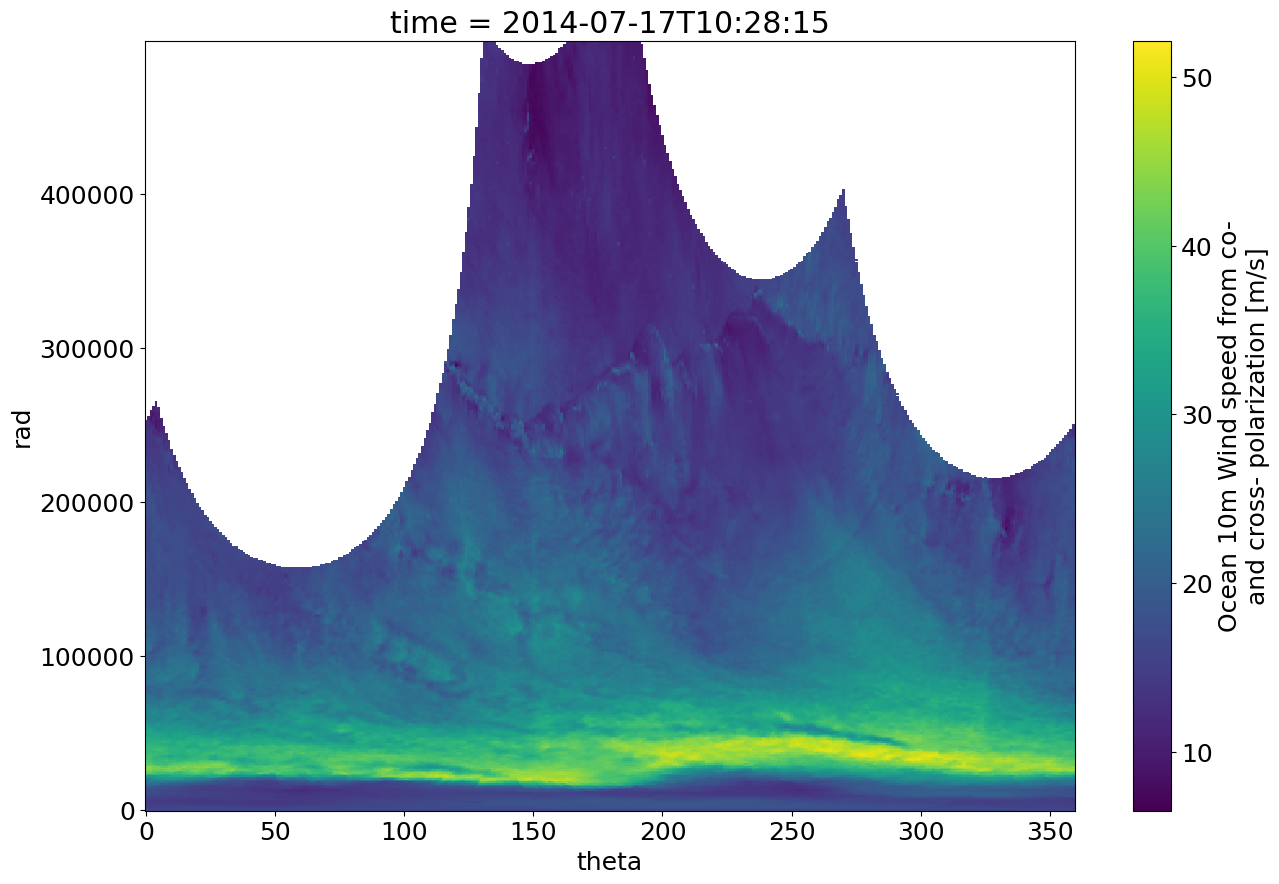

In [25]:
dsp.wind_speed.plot()

In [14]:
#########################
###  HYPERPARAMETERS  ###
#########################
### Reference grids
rs            = np.linspace(1000, 5e5, 500)
ths           = np.linspace(0, 2 * np.pi, 361)                           # in radians
zs            = np.array([10])
Rs, THs       = np.meshgrid(rs, ths)                                     # shape (361, 5000)

# Vectorize on dim z
THs           = np.repeat(np.expand_dims(THs, axis=0), len(zs),  axis=0) # shape e.g (len(zs), 361, 5000)
Rs            = np.repeat(np.expand_dims(Rs,  axis=0), len(zs),  axis=0) # shape e.g (len(zs), 361, 5000)
Zs            = np.repeat(np.expand_dims(zs,  axis=1), len(ths), axis=1) # shape e.g (len(zs), 361, 5000)
Zs            = np.repeat(np.expand_dims(Zs,  axis=2), len(rs),  axis=2) # shape e.g (len(zs), 361, 5000)

# To create cartesian dataset
Xs, Ys        = pol2cart(Rs, THs)                                        # to create cartesian dataset
dim_ref       = np.linspace(-500, 500, int((500 // 1 * 2) + 1)) * 1000   # to create cartesian dataset
x_ref, y_ref  = np.meshgrid(dim_ref, dim_ref)                            # to create cartesian dataset

# To compute asymmetries
xs            = np.linspace(1000, 250000, 250)

# Ref. height
z_ref         = 10

In [15]:
# Prepare new_dsg
listOfDatasets  = []

for t in tqdm(range(len(dsg_filtered.time))):
    # Open
    ds  = dsg_filtered.isel(time=t)
    dsp = xr.open_dataset(PTHS['sar_dir'] + ds.file_tcva.item()).isel(time=0)

    # Determined parameters
    vmx = float(ds.vmx_hol)
    rmx = float(ds.rmx_hol)
    vmn = float(ds.vmn_hol)
    B   = float(ds.B_hol)
    lat = float(ds.lat)
    fcr = abs(float(ds.fcor))
    Ut  = float(ds.speed)
    
    # Holland
    V    = holland_profile(rs, lat, B, vmn, rmx, vmx)
    Vs   = np.stack([V for i in range(np.shape(THs)[1])]) # Shape (361, 5000)
    Vs   = np.repeat(np.expand_dims(Vs, axis=0), len(zs), axis=0)
    
    # Sign due to hemisphere
    h    = 1 if lat > 0 else -1

    #############################
    ### TURBULENT PARAMETERS  ###
    #############################
    cd_lp          = np.ones_like(V) * 1e-3 # Large and Pond
    K_kpp          = np.ones_like(V)        # KPP
    
    rmax_to_r0     = (rs >= float(ds.rmx)) & (rs <= float(ds.r0))

    try:
        ### C - Large and Pond formulation, averaged (cylindrical)
        # For V > 10.92 m/s
        cd_lp[V <= 10.92] = 1.2e-3 # We use 10.92 instead of 11 to ensure continuity of Cd
        low_ws            = (V > 10.92)
        cd_lp[low_ws]     = (0.49 + 0.065 * V[low_ws]) * 1e-3
        # For V > 38.62 m/s
        hgh_ws            = (V > 38.62)
        cd_lp[hgh_ws]     = 3 * 1e-3
        # Cylindrical average
        cd_mean_lp        = 2 * np.trapezoid(cd_lp[rmax_to_r0] * rs[rmax_to_r0], rs[rmax_to_r0]) / (float(ds.r0 - ds.rmx) ** 2)

        ### K - KPP formulation, averaged (cylindrical)
        # K_kpp      = (1 / 12) * 0.4 * 1000 * V * np.sqrt(cd_lp)                                  # Simpler form, Zhang and Drennan 2012  
        K_kpp      = (0.25 / 12) * 0.4 * 500  * V * np.sqrt(cd_lp) + 10 * 0.4 * V * np.sqrt(cd_lp) # h = 500m and H = 2km                         
        # K_kpp      = (0.5 / 12) * 0.4 * 1000 * V * np.sqrt(cd_lp) + 10 * 0.4 * V * np.sqrt(cd_lp) # h = 1km and H = 2km
        K_mean_kpp = 2 * np.trapezoid(K_kpp[rmax_to_r0] * rs[rmax_to_r0], rs[rmax_to_r0]) / (float(ds.r0 - ds.rmx) ** 2)
        
    except IndexError:
        cd_mean_lp = K_mean_kpp = np.nan

    ds['cd_mean_lp'] = cd_mean_lp
    ds['K_mean_kpp'] = K_mean_kpp

    if (~np.isnan(cd_mean_lp)) & (~np.isnan(K_mean_kpp)):
        #####################
        ### Extract. sol. ###
        #####################
        # Wind at gradient level
        wrf    = wind_reduction_factor(Rs, Vs, K_mean_kpp, cd_mean_lp, fcr) # azimuthal wind
        Vs_try = Vs / wrf
        
        # Get K01
        u_K01, v_K01 = kepert2001(THs, Rs, Vs_try, Ut, K_mean_kpp, cd_mean_lp, fcr, Zs, z_ref, h)
        
        # Get polar dataset
        kep_pol      = get_xrDataset_polar(zs, ths, rs, u_K01, v_K01)
        
        # Compute asymmetries on Kepert wind field
        aks         = []
        pks         = []
        # Iterate over all radii
        for rad in xs: # Iterate only in the valid range to optimize time
            try:
                ak, phi, _  = get_wn1(np.deg2rad(kep_pol.sel(z=10).theta), kep_pol.sel(z=10).wind_speed.sel(rad=rad, method='nearest'), np.max(Vs[0, 0, :]) / 3, np.max(Vs[0, 0, :]))
            except RuntimeError:
                ak = phi = np.nan
            aks.append(ak)
            pks.append(phi)
    
        # Non-C1 points?
        I__V_r       = I(Rs, Vs_try, fcr)[0, :, :].mean(axis=0) - Vs_try[0, :, :].mean(axis=0) / rs
        ds['non_C1'] = (np.count_nonzero(I__V_r[rs >= rmx] < 0) > 0)
        
        #################
        ### SAR asym. ###
        #################
        # Initialize
        LWS = [] # To save the Holland wind speeds
        ERR = [] # To compute RMSE
        ACN = [] # Amplitude of cosine
        PHS = [] # Phase of cosine
        VTS = [] # Nb of valid thetas
    
        # Fit Holland for each theta
        for th in th_steps:
            ds_slice          = dsp.sel(theta=slice(th, th + th_delta))
            wsm               = ds_slice.wind_speed.mean(dim='theta', skipna=True)
            r_crop, spdm_crop = initialize_radius(np.array(wsm))
        
            try:
                # Holland
                popt, pcov = curve_fit(
                    lambda r, B, Vmin, Rmax, Vmax: holland_profile(r, lat, B, Vmin, Rmax, Vmax), 
                    np.array(r_crop), 
                    np.array(spdm_crop), 
                    p0=[1.8, 5, 20 * 1000, 40], 
                    bounds=(
                        tuple([BDS_HOL[e][0] for e in BDS_HOL.keys()]), # NB: lat is fixed
                        tuple([BDS_HOL[e][1] for e in BDS_HOL.keys()])
                    ) 
                ) 
                B_hol, vmn_hol, rmx_hol, vmx_hol = popt
                
            except RuntimeError:
                B_hol = vmn_hol = rmx_hol = vmx_hol = np.nan
            
            # Append
            LWS.append(holland_profile(rs, lat, B_hol, vmn_hol, rmx_hol, vmx_hol))
    
        # Create dataset with Holland for each theta
        dsh = xr.Dataset(
            data_vars={
                'ws':        (('th', 'rad'), LWS),
            },
            coords={
                'th': th_steps,
                'rad': rs,
            }
        )
        
        # Compute asymmetries
        for rad in xs:
            # Amplitude of cosine
            if np.count_nonzero(np.isnan(dsh.sel(rad=rad, method='nearest').ws)) == 0:
                try:
                    acn, phi, c = get_wn1(np.deg2rad(dsh.sel(rad=rad, method='nearest').th), dsh.sel(rad=rad, method='nearest').ws, float(ds.vmx) / 3, float(ds.vmx))
                except RuntimeError:
                    acn = phi = c = np.nan
            else:
                acn = phi = c = np.nan
            ACN.append(acn)
            PHS.append(phi)
            # Error
            error         = float(rmse(dsh.sel(rad=rad, method='nearest').ws, wn1(np.deg2rad(dsh.th), acn, phi, c))) 
            ERR.append(error)
            # Valid thetas
            VTS.append(len(dsp.sel(rad=rad, method='nearest').dropna(subset=['wind_speed'], dim='theta').theta))
    
        ### Validation metrics
        # Asymmetry amplitude metrics
        ds['max_asym_sar']  = np.nanmax(np.array(ACN)[xs >= rmx])
        ds['max_asym_K01']  = np.nanmax(np.array(aks)[xs >= rmx])
        ds['asym_avg_err']  = rmse(np.array(aks)[xs >= rmx], np.array(ACN)[xs >= rmx])
        # Asymmetry phase metrics
        a_sar               = (np.rad2deg(PHS) % 360)[xs >= rmx]
        a_K01               = (np.rad2deg(pks) % 360)[xs >= rmx]
        ds['phase_avg_err'] = np.nanmean(np.minimum(abs(a_sar - a_K01), 360 - abs(a_sar - a_K01)))
    
        ############
        ### Plot ###
        ############
        if PRMS['sav_fgs']:
            fig          = plt.figure(figsize=(20, 20))
            gs           = GridSpec(4, 2, hspace=0.24, wspace=0.21)
            cmap         = plt.get_cmap('PuOr') # Spectral
            normalizer   = Normalize(0, 80)
            ax_lims      = 250
            ts           = pd.to_datetime(str(ds.time.values)) 
            d            = ts.strftime('%Y-%m-%d, %H:%M')
            plt.suptitle('{}, {}, {} UTC \nTranslation speed = {:.1f} m/s'.format(ds.name.item(), ds.id.item(), d, ds.speed), y=0.92)
            
            ### Plot SAR
            ax           = fig.add_subplot(gs[0, :])
            dr, th       = np.meshgrid(dsp.rad, np.deg2rad(dsp.theta))
            ds_x, ds_y   = pol2cart(dr, th)
            ws_car       = griddata((ds_x.flatten(), ds_y.flatten()), np.array(dsp.wind_speed.transpose()).flatten(), (x_ref, y_ref), method='linear')
            im           = ax.pcolormesh(x_ref / 1000, y_ref / 1000, ws_car, cmap=cwnd, norm=normalizer)
            
            # Axes
            ax.set_xlim(-ax_lims, ax_lims);ax.set_ylim(-ax_lims, ax_lims)
            ax.set_ylabel(r'Distance from TC center (km)')
            ax.set_xlabel(r'Distance from TC center (km)')
            # ax.set_box_aspect(1)
            ax.minorticks_on()
            ax.tick_params(length=7, width=1.2)
            ax.grid()
            
            ax2 = ax.twinx().twiny() 
            ax2.set_xlim(-ax_lims, ax_lims);ax2.set_ylim(-ax_lims, ax_lims)
            ax2.minorticks_on()
            ax2.tick_params(axis='both', length=7, width=1.2)
            ax2.set_box_aspect(1)
            ax2.set_yticklabels([])
            ax2.set_xticklabels([])
            
            # Colorbar
            cb_ax = fig.add_axes([0.6, 0.717, 0.014, 0.163])
            cbar  = fig.colorbar(im, cax=cb_ax)
            cbar.set_label(r'Wind speed (m/s)', rotation=90)
            cbar.ax.get_yaxis().labelpad=5
            
            ### Plot wind field SAR
            ax       = fig.add_subplot(gs[1, 0])
            ax.pcolormesh(dsp.wind_speed.transpose(), cmap=cwnd, norm=normalizer)
            ax.set_xlabel(r'Distance from TC center (km)')
            ax.set_ylabel(r'Azimuth (deg)')
            ax.set_xlim(0, ax_lims)
            
            ### Plot wind field Kepert
            ax       = fig.add_subplot(gs[1, 1])
            ax.pcolormesh(Rs[0, :, :] / 1000, np.rad2deg(THs[0, :, :]), kep_pol.sel(z=10).wind_speed, cmap=cwnd, norm=normalizer)
            ax.set_xlabel(r'Distance from TC center (km)')
            ax.set_ylabel(r'Azimuth (deg)')
            ax.set_xlim(0, ax_lims)
            
            ### Plot wind profiles (SAR + Kepert)
            ax       = fig.add_subplot(gs[2, 0])
            ax.plot(rs / 1000,  kep_pol.sel(z=10).wind_speed.mean(dim='theta'), c='tab:red', label='Model')
            ax.plot(rs / 1000,  Vs[0, 0, :], c='k', linewidth=3, label='SAR (Holland fit)')
            ax.plot(dsp.rad / 1000, dsp.wind_speed.mean(dim='theta'), c='k', linestyle='dashed', label='SAR (Obs)')
            ax.legend(frameon=False)
            ax.set_xlabel(r'Distance from TC center (km)')
            ax.set_ylabel(r'Wind speed (m/s)')
            ax.set_xlim(0, ax_lims)
            ax.grid()
            
            ### Plot conditional curves to highlight non-C1 points
            ax       = fig.add_subplot(gs[2, 1])
            ax.plot(rs / 1000, I__V_r, c='k', linewidth=3)
            ax.axhline(0, c='gray', linewidth=3)
            ax.set_xlabel(r'Distance from TC center (km)')
            ax.set_ylabel(r'I - V/r (s-1)')
            ax.set_xlim(0, ax_lims)
            ax.set_ylim(-0.00001, 0.0002)
            ax.grid()
            
            ### Plot asymmetries (SAR + Kepert)
            ax       = fig.add_subplot(gs[3, 0])
            
            ax.plot(xs / 1000, ACN, c='k', linewidth=3,                 label='Amplitude of cosine to Holland fit')
            ax.plot(xs / 1000, ERR, c='tab:purple', linestyle='dashed', label='RMSE in fitting cosine (non-avg.)')
            # Kepert asymmetry profiles
            ax.plot(xs / 1000, aks,                 c='tab:red',                        label='Model')
            # Wind radii
            ax.axvline(ds.rmx / 1000,                      c='k',    linewidth=3,        label='Rmax')
            ax.axvline(ds.rps / 1000,                      c='k',                        label='R+')
            ax.axvline(ds.r0 / 1000,                       c='k',    linestyle='dashed', label='R0')
            
            # Validity curves
            ax.plot(xs / 1000, np.array(VTS) / 360., c='green',                          label='Percentage of valid thetas - must be close to 1')
            # ax.plot(xs / 1000, Ut / Vs[0, idxs],      c='green',      linestyle='dashed', label='Ut / V - must remain small')
            ax.axhline(1, c='gray', alpha=0.3)
            
            # Legends
            ax.set_xlabel(r'Distance from TC center (km)')
            ax.set_ylabel('Asym. WN1 amp. (m/s)')
            ax.legend(loc='lower center', bbox_to_anchor=(1.06, -0.62), ncol=3, fancybox=True, shadow=True)
            # ax.set_xlim(0, max(float(ds.r0 / 1000) + 5, 250))
            ax.set_xlim(0, ax_lims)
            ax.set_ylim(0, 0.2 + float(np.nanmax([max(ACN), max(ERR), np.nanmax(aks)])))
            ax.grid()
            
            ### Phase of max. asymmetry
            ax       = fig.add_subplot(gs[3, 1])
            ax.plot(xs / 1000,  np.rad2deg(pks) % 360, c='tab:red', label='Model')
            ax.plot(xs / 1000,  np.rad2deg(PHS) % 360, c='k', linewidth=3, label='SAR')
            ax.axvline(ds.rmx / 1000,    c='k', linewidth=3)
            ax.axvline(ds.rps / 1000,    c='k')
            ax.axvline(ds.r0  / 1000,    c='k', linestyle='dashed')
            # ax.legend(frameon=False)
            ax.set_xlabel(r'Distance from TC center (km)')
            ax.set_ylabel(r'Phase of max. asym. (deg)')
            ax.set_xlim(0, ax_lims)
            ax.grid()
    
            # Save
            plt.savefig(PTHS['sav_dir'] + 'figs/{}.png'.format(ds.file_tcva.item()[:-17]), bbox_inches='tight', format='png');plt.clf()
    
        # Concatenate
        listOfDatasets.append(ds)                   # Append to list of xarray.Dataset
    
        # Close
        dsp.close()
    
        # Save cases
        if PRMS['sav_css']:
            kep_pol['cd_mean_lp'] = cd_mean_lp
            kep_pol['K_mean_kpp'] = K_mean_kpp
            kep_pol['file_tcva']  = ds.file_tcva.item()
            kep_pol.to_netcdf(PTHS['sav_dir'] + 'cases/{}.nc'.format(ds.file_tcva.item()[:-17]))

# Concatenate
print('Concatenating all datasets into ds_glob. Can take a few seconds...')
new_dsg = xr.concat(listOfDatasets, dim='time') # Concatenate all datasets into a global dataset
print('Concatenation ended.')

  0%|          | 0/472 [00:00<?, ?it/s]

/tmp/ipykernel_44558/4042933452.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig          = plt.figure(figsize=(20, 20))
/tmp/ipykernel_44558/4042933452.py:155: RuntimeWarning: All-NaN slice encountered
  ds['max_asym_sar']  = np.nanmax(np.array(ACN)[xs >= rmx])
/tmp/ipykernel_44558/4042933452.py:161: RuntimeWarning: Mean of empty slice
  ds['phase_avg_err'] = np.nanmean(np.minimum(abs(a_sar - a_K01), 360 - abs(a_sar - a_K01)))
/tmp/ipykernel_44558/4042933452.py:155: RuntimeWarning: All-NaN slice encountered
  ds['max_asym_sar']  = np.nanmax(np.array(ACN)[xs >= rmx])
/tmp/ipykernel_44558/4042933452.py:161: RuntimeWarning: Mean of empty slice
  ds['phase_avg_err'] = np.nanmean(np.minimum(abs(a_sar - a_K01), 360 - 

Concatenating all datasets into ds_glob. Can take a few seconds...
Concatenation ended.


<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

In [16]:
### SAVE
new_dsg.to_netcdf(PTHS['sav_dir'] + 'dsg_K01_prm.nc')